In [59]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import hog
from sympy import sympify
import cv2
import matplotlib.pyplot as plt


In [60]:
data_dir = "data"
img_size = 45

# Collect labels
symbol_labels = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

# Label mappings
symbol_to_index = {label: idx for idx, label in enumerate(symbol_labels)}
index_to_label = {v: k for k, v in symbol_to_index.items()}

X_symbols, y_symbols = [], []

# Load dataset images
for label in symbol_labels:
    folder_path = os.path.join(data_dir, label)
    for file in os.listdir(folder_path):
        if file.endswith(".jpg"):
            try:
                img_path = os.path.join(folder_path, file)
                img = load_img(img_path, color_mode="grayscale", target_size=(img_size, img_size))
                img = img_to_array(img) / 255.0
                X_symbols.append(img)
                y_symbols.append(symbol_to_index[label])
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

# Convert to numpy arrays
X_all = np.array(X_symbols)
y_all = np.array(y_symbols)

print("Dataset loaded:", X_all.shape, y_all.shape)
print("Classes:", index_to_label)


Dataset loaded: (362870, 45, 45, 1) (362870,)
Classes: {0: '!', 1: '(', 2: ')', 3: '+', 4: ',', 5: '-', 6: '0', 7: '1', 8: '2', 9: '3', 10: '4', 11: '5', 12: '6', 13: '7', 14: '8', 15: '9', 16: 'A', 17: 'C', 18: 'Delta', 19: 'G', 20: 'H', 21: 'M', 22: 'N', 23: 'R', 24: 'S', 25: 'T', 26: 'X', 27: '[', 28: ']', 29: 'alpha', 30: 'ascii_124', 31: 'b', 32: 'beta', 33: 'cos', 34: 'd', 35: 'div', 36: 'e', 37: 'exists', 38: 'f', 39: 'forall', 40: 'forward_slash', 41: 'gamma', 42: 'geq', 43: 'gt', 44: 'i', 45: 'in', 46: 'infty', 47: 'int', 48: 'j', 49: 'k', 50: 'l', 51: 'lambda', 52: 'ldots', 53: 'leq', 54: 'lim', 55: 'log', 56: 'lt', 57: 'mu', 58: 'neq', 59: 'o', 60: 'p', 61: 'phi', 62: 'pi', 63: 'pm', 64: 'prime', 65: 'q', 66: 'rightarrow', 67: 'sigma', 68: 'sin', 69: 'sqrt', 70: 'sum', 71: 'tan', 72: 'theta', 73: 'times', 74: 'u', 75: 'v', 76: 'w', 77: 'y', 78: 'z', 79: '{', 80: '}'}


In [61]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Extract HOG features
def extract_hog_features(images):
    features = []
    for img in images:
        img = img.squeeze()  # (45,45)
        hog_feat = hog(
            img,
            orientations=9,
            pixels_per_cell=(4,4),
            cells_per_block=(2,2),
            block_norm="L2-Hys"
        )
        features.append(hog_feat)
    return np.array(features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

print("HOG feature shape (per image):", X_train_hog.shape[1])

HOG feature shape (per image): 3600


In [62]:
rf_hog = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_hog.fit(X_train_hog, y_train)

# Evaluate
y_pred_hog = rf_hog.predict(X_test_hog)
print("Accuracy:", accuracy_score(y_test, y_pred_hog))
print("\nClassification report:\n",
      classification_report(y_test, y_pred_hog,
                            target_names=[index_to_label[i] for i in sorted(index_to_label)]))

Accuracy: 0.9965827982473062

Classification report:
                precision    recall  f1-score   support

            !       1.00      1.00      1.00       282
            (       1.00      1.00      1.00      2837
            )       1.00      1.00      1.00      2877
            +       1.00      1.00      1.00      5063
            ,       0.96      0.93      0.94       366
            -       1.00      1.00      1.00      6775
            0       0.99      1.00      1.00      1395
            1       0.99      0.99      0.99      5325
            2       1.00      1.00      1.00      5190
            3       0.99      1.00      1.00      2177
            4       1.00      1.00      1.00      1534
            5       1.00      0.99      0.99       720
            6       1.00      0.99      0.99       611
            7       1.00      0.99      1.00       555
            8       1.00      1.00      1.00       616
            9       1.00      0.99      1.00       774
          

In [63]:
import joblib

joblib.dump(rf_hog, "models/rf_hog.pkl")

['models/rf_hog.pkl']

In [64]:
#rf_hog = joblib.load("random_forest_hog.pkl")

#y_pred = rf_hog.predict(X_test_hog)
#print("Loaded model accuracy:", accuracy_score(y_test, y_pred))

In [65]:
def solve_expression(expr):
    # Safely evaluate a math expression string. Uses sympy to avoid Python's eval() risks.
    try:
        result = sympify(expr).evalf()  # sympy safely parses the math expression
        return result
    except Exception as e:
        return f"Error solving expression: {e}"


In [66]:
def segment_expression(img_path, img_size=45, show_steps=False):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Threshold (invert so text is white)
    _, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    symbol_imgs = []
    bounding_boxes = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Skip very small contours
        #if w < 2 or h < 2:
            #continue

        roi = thresh[y:y+h, x:x+w]

        # Add padding to make square
        side = max(w, h)
        square = np.zeros((side, side), dtype=np.uint8)
        square[(side-h)//2:(side-h)//2+h, (side-w)//2:(side-w)//2+w] = roi

        # Resize to 45x45
        roi_resized = cv2.resize(square, (img_size, img_size), interpolation=cv2.INTER_AREA)

        # Normalize
        roi_resized = roi_resized.astype("float32") / 255.0
        roi_resized = np.expand_dims(roi_resized, axis=-1)

        symbol_imgs.append(roi_resized)
        bounding_boxes.append((x, y, w, h))

    # Sort symbols left-to-right
    sorted_symbols = [s for _, s in sorted(zip(bounding_boxes, symbol_imgs), key=lambda b: b[0][0])]

    if show_steps:
        plt.imshow(thresh, cmap="gray")
        plt.title("Thresholded image")
        plt.show()

        for i, s in enumerate(sorted_symbols):
            plt.subplot(1, len(sorted_symbols), i+1)
            plt.imshow(s.squeeze(), cmap="gray")
            plt.axis("off")
        plt.show()

    return sorted_symbols


In [67]:
def classify_expression(img_path):
    symbols = segment_expression(img_path, img_size=45, show_steps=True)
    predicted_chars = [predict_symbol_rf_hog(s) for s in symbols]
    return "".join(predicted_chars)

def solve_expression(expr):
    try:
        return sympify(expr).evalf()
    except Exception as e:
        return f"Error: {e}"

In [68]:
# Predicting with hog instead of just RF
def predict_symbol_rf_hog(img):
    img = img.squeeze()
    hog_feat = hog(
        img,
        orientations=9,
        pixels_per_cell=(4, 4),
        cells_per_block=(2, 2),
        block_norm="L2-Hys"
    ).reshape(1, -1)

    probs = rf_hog.predict_proba(hog_feat)[0]

    for cls, p in zip(rf_hog.classes_, probs):
        print(f"{cls}: {p:.2f}")

    pred_idx = rf_hog.predict(hog_feat)[0]
    return index_to_label[pred_idx]

In [69]:
# Sanity check
test_symbol = segment_expression("test_images/math_img.png", img_size=45)[0]
print("Segment shape:", test_symbol.shape)

from skimage.feature import hog
feat = hog(test_symbol.squeeze(),
           orientations=9,
           pixels_per_cell=(4,4),
           cells_per_block=(2,2),
           block_norm="L2-Hys").reshape(1,-1)
print("HOG length:", feat.shape[1])

Segment shape: (45, 45, 1)
HOG length: 3600


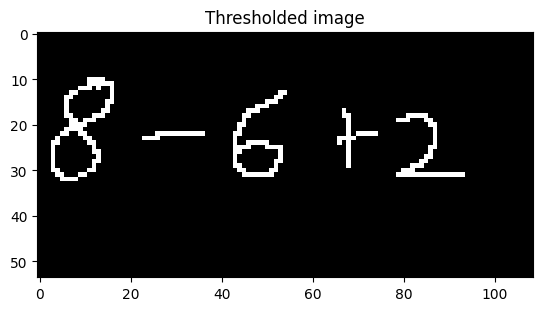

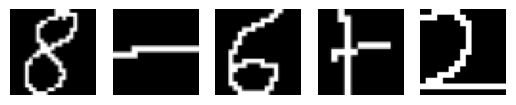

0: 0.01
1: 0.02
2: 0.01
3: 0.03
4: 0.01
5: 0.00
6: 0.01
7: 0.06
8: 0.04
9: 0.05
10: 0.03
11: 0.03
12: 0.03
13: 0.01
14: 0.09
15: 0.03
16: 0.01
17: 0.01
18: 0.00
19: 0.02
20: 0.01
21: 0.00
22: 0.01
23: 0.01
24: 0.00
25: 0.01
26: 0.01
27: 0.01
28: 0.01
29: 0.01
30: 0.01
31: 0.07
32: 0.01
33: 0.00
34: 0.01
35: 0.00
36: 0.01
37: 0.00
38: 0.05
39: 0.00
40: 0.01
41: 0.00
42: 0.00
43: 0.00
44: 0.04
45: 0.00
46: 0.00
47: 0.01
48: 0.03
49: 0.01
50: 0.00
51: 0.00
52: 0.00
53: 0.01
54: 0.00
55: 0.01
56: 0.01
57: 0.00
58: 0.00
59: 0.00
60: 0.02
61: 0.01
62: 0.01
63: 0.00
64: 0.00
65: 0.01
66: 0.00
67: 0.00
68: 0.00
69: 0.01
70: 0.00
71: 0.00
72: 0.03
73: 0.01
74: 0.00
75: 0.01
76: 0.00
77: 0.04
78: 0.04
79: 0.01
80: 0.00
0: 0.00
1: 0.00
2: 0.00
3: 0.02
4: 0.00
5: 0.87
6: 0.00
7: 0.00
8: 0.01
9: 0.00
10: 0.00
11: 0.00
12: 0.00
13: 0.00
14: 0.00
15: 0.00
16: 0.00
17: 0.00
18: 0.00
19: 0.00
20: 0.00
21: 0.00
22: 0.00
23: 0.00
24: 0.00
25: 0.00
26: 0.00
27: 0.00
28: 0.00
29: 0.00
30: 0.00
31: 0.00
32:

In [70]:
# Example: feed an image
expr_img = "test_images/math_img.png"

expr_str = classify_expression(expr_img)
print("Recognized expression:", expr_str)

result = solve_expression(expr_str)
print("Result:", result)


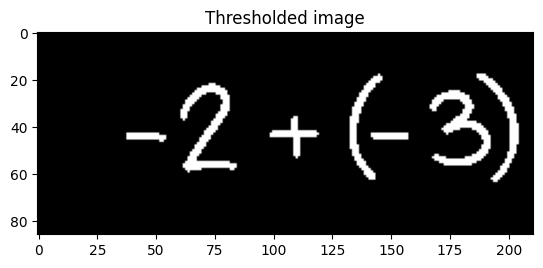

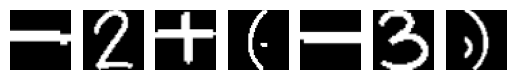

0: 0.00
1: 0.00
2: 0.00
3: 0.01
4: 0.00
5: 0.70
6: 0.00
7: 0.01
8: 0.03
9: 0.00
10: 0.00
11: 0.01
12: 0.00
13: 0.00
14: 0.00
15: 0.00
16: 0.00
17: 0.00
18: 0.00
19: 0.00
20: 0.00
21: 0.01
22: 0.01
23: 0.00
24: 0.00
25: 0.01
26: 0.01
27: 0.00
28: 0.00
29: 0.00
30: 0.00
31: 0.00
32: 0.00
33: 0.00
34: 0.00
35: 0.00
36: 0.00
37: 0.00
38: 0.00
39: 0.00
40: 0.00
41: 0.00
42: 0.00
43: 0.00
44: 0.00
45: 0.00
46: 0.01
47: 0.00
48: 0.00
49: 0.00
50: 0.01
51: 0.00
52: 0.01
53: 0.00
54: 0.00
55: 0.00
56: 0.00
57: 0.00
58: 0.00
59: 0.00
60: 0.00
61: 0.00
62: 0.00
63: 0.00
64: 0.00
65: 0.00
66: 0.13
67: 0.00
68: 0.00
69: 0.06
70: 0.00
71: 0.01
72: 0.00
73: 0.00
74: 0.00
75: 0.00
76: 0.00
77: 0.00
78: 0.00
79: 0.00
80: 0.00
0: 0.01
1: 0.02
2: 0.01
3: 0.01
4: 0.02
5: 0.00
6: 0.01
7: 0.10
8: 0.27
9: 0.01
10: 0.01
11: 0.01
12: 0.01
13: 0.01
14: 0.01
15: 0.01
16: 0.01
17: 0.01
18: 0.00
19: 0.01
20: 0.01
21: 0.00
22: 0.01
23: 0.01
24: 0.00
25: 0.02
26: 0.04
27: 0.04
28: 0.01
29: 0.00
30: 0.01
31: 0.03
32:

In [71]:
# Example: feed an image
expr_img = "test_images/math.png"

expr_str = classify_expression(expr_img)
print("Recognized expression:", expr_str)

result = solve_expression(expr_str)
print("Result:", result)